# 1. 시계열 분석(다변량)

## 1-1. 데이터의 적합성 및 정상성을 판단하시오.

In [291]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima_model import ARMA,ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.stats.diagnostic import acorr_ljungbox,het_goldfeldquandt
from scipy import stats
from scipy.signal import savgol_filter

import itertools
from sklearn.metrics import r2_score
np.random.seed(123)

In [2]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [9]:
train.set_index('date',inplace = True)
test.set_index('date',inplace = True)

In [11]:
def plot_rolling(data, interval):
    
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()

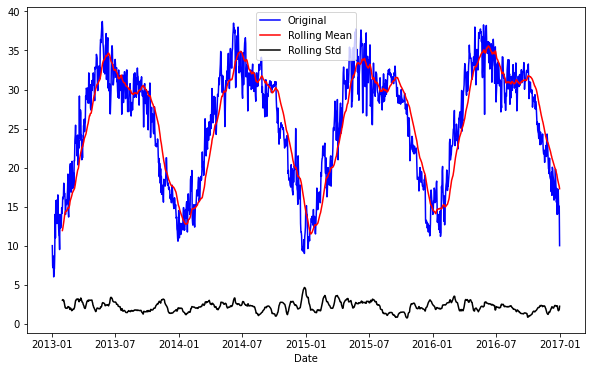

In [14]:
plot_rolling(train['meantemp'],30)

- 평균이 일정하지 않다.

In [29]:
def adfuller_test(data) :
    result = adfuller(data)
    print("원 데이터의 ADF 값 : {}".format(result[0]))
    print('원 데이터의 P-value : {}'.format(result[1]))
    
    result_diff = adfuller(data.diff().dropna())
    print('\n1차 차분 후 검정')
    print('ADF : {}'.format(result_diff[0]))
    print("ADF P-value : {}\n".format(result_diff[1]))

In [30]:
for col in train.columns :
    print("{}'s Adfuller Test".format(col.capitalize()))
    print(adfuller_test(train[col]))

Meantemp's Adfuller Test
원 데이터의 ADF 값 : -2.021069055920671
원 데이터의 P-value : 0.2774121372301611

1차 차분 후 검정
ADF : -16.378720267074716
ADF P-value : 2.764863137594368e-29

None
Humidity's Adfuller Test
원 데이터의 ADF 값 : -3.675576919163347
원 데이터의 P-value : 0.004470100478130632

1차 차분 후 검정
ADF : -12.683532100905571
ADF P-value : 1.1729233587042856e-23

None
Wind_speed's Adfuller Test
원 데이터의 ADF 값 : -3.8380967566851063
원 데이터의 P-value : 0.002540722153146385

1차 차분 후 검정
ADF : -12.8377197386057
ADF P-value : 5.693418829796311e-24

None
Meanpressure's Adfuller Test
원 데이터의 ADF 값 : -38.078590025561624
원 데이터의 P-value : 0.0

1차 차분 후 검정
ADF : -12.945640488663106
ADF P-value : 3.460494014132185e-24

None


- meantemp가 1차 차분 이후에 귀무가설을 기각하여 정상성을 가지므로 1차 차분을 하는 것이 좋을 것이다.

In [32]:
def kpss_test(data) :
    statistic, p_value, n_lags, critial_values = kpss(data.values)
    
    print("KPSS Statistic : {}".format(statistic))
    print("P-value : {}".format(p_value))
    print("num_lags : {}".format(n_lags))
    print("Critial_values : {}".format(critial_values))
    
    diff = data.diff().dropna()
    
    statistic_diff, p_value_diff, n_lags_diff, critial_values_diff = kpss(diff.values)
    print("\n 1차 차분 후 검정")
    print("KPSS Statistic : {}".format(statistic_diff))
    print("P-value : {}".format(p_value_diff))
    print("num_lags : {}".format(n_lags_diff))
    print("Critial_values : {}\n".format(critial_values_diff))

In [65]:
for col in train.columns :
    print("{}'s KPSS Test".format(col.capitalize()))
    print(kpss_test(train[col]))

Meantemp's KPSS Test
KPSS Statistic : 0.1948270141059301
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 1차 차분 후 검정
KPSS Statistic : 0.2353813484835482
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

None
Humidity's KPSS Test
KPSS Statistic : 0.09173654899480822
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 1차 차분 후 검정
KPSS Statistic : 0.0682555242827157
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

None
Wind_speed's KPSS Test
KPSS Statistic : 0.11539895100903955
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 1차 차분 후 검정
KPSS Statistic : 0.03291806592134817
P-value : 0.1
num_lags : 24
Critial_values : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

None
Meanpressure's KPSS Test
KPSS Statistic : 0.086567288

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\qhadk\App

- kpss의 경우 차분 전과 후는 귀무가설을 채택하기에 정상성 시계열을 만족하지만, adf_test를 수행한 경우에는 1차 차분을 진행하여야 정상성을 만족하게 된다. 그래서 1차 차분 수행

In [34]:
from statsmodels.tsa.api import VAR

In [37]:
X_train = train.diff().dropna()

Meantemp Plot


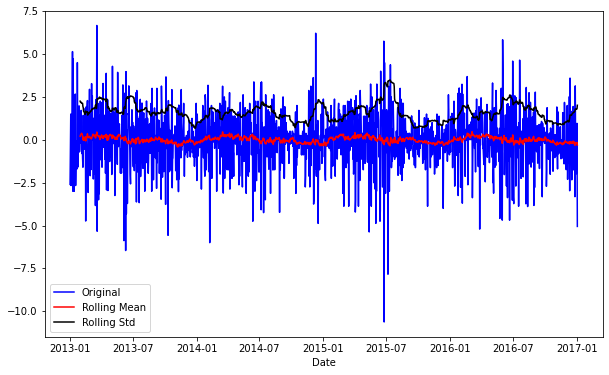

Humidity Plot


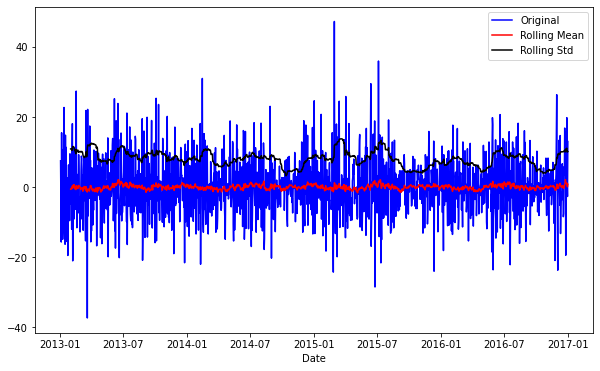

Wind_speed Plot


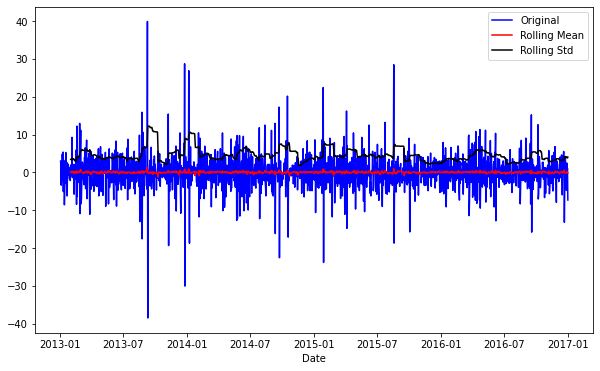

Meanpressure Plot


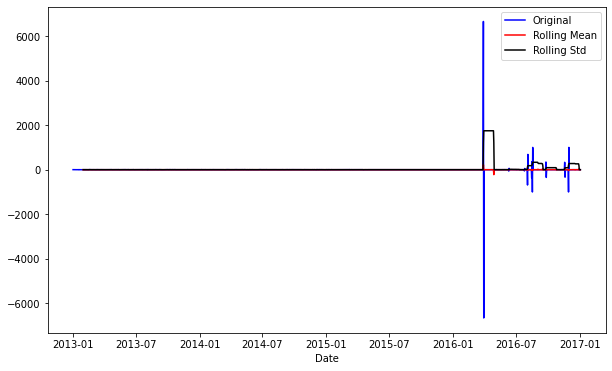

In [68]:
for col in X_train.columns :
    print("{} Plot".format(col.capitalize()))
    plot_rolling(X_train[col],30)

- 평균과 분산이 일정

## 1-2. 시계열 분석 기법 3가지를 각각 소개하고 기법들을 활용하여 test세트로 예측을 수행하시오.
- 모든 feature 예측값 출력

In [71]:
forecasting_model = VAR(X_train)

results_aic = []
for p in range(1,20) :
    results = forecasting_model.fit(p)
    results_aic.append(results.aic)

C:\Users\qhadk\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


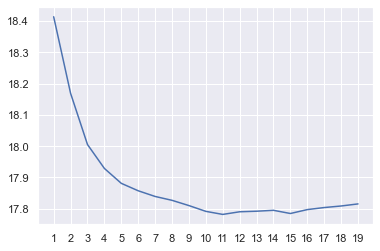

In [76]:
sns.set()
plt.plot(list(np.arange(1,20,1)),results_aic)
plt.xticks(list(np.arange(1,20,1)))
plt.show()

In [86]:
for i,v in enumerate(results_aic) :
    if v == min(results_aic) :
        print(i)

10


In [87]:
results = forecasting_model.fit(11)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 03, Jun, 2021
Time:                     13:28:51
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    18.4374
Nobs:                     1450.00    HQIC:                   18.0266
Log likelihood:          -20941.8    FPE:                5.28048e+07
AIC:                      17.7820    Det(Omega_mle):     4.67284e+07
--------------------------------------------------------------------
Results for equation meantemp
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.000463         0.041797            0.011           0.991
L1.meantemp             -0.185976         0.035808           -5.194           0.000
L1.humidity              0.009695         0.0

In [97]:
lagged_values = X_train.values[-11:]

In [287]:
forecast  = pd.DataFrame(results.forecast(y = lagged_values,steps = len(test)),index=test.index,columns=test.columns)

In [288]:
forecast

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,1.360047,-8.829019,4.344237,4.762878
2017-01-02,0.964909,-3.332371,-0.063685,48.380433
2017-01-03,0.823800,-0.597647,0.279147,-56.665909
2017-01-04,0.065619,0.332586,0.976988,-21.924276
2017-01-05,-0.248478,0.612326,0.062867,18.567387
...,...,...,...,...
2017-04-20,0.000459,0.011550,-0.002056,0.000635
2017-04-21,0.000459,0.011550,-0.002056,0.000637
2017-04-22,0.000459,0.011550,-0.002056,0.000639


## 1-3. 각 기법별로 사후 분석을 수행하시오.

meantemp


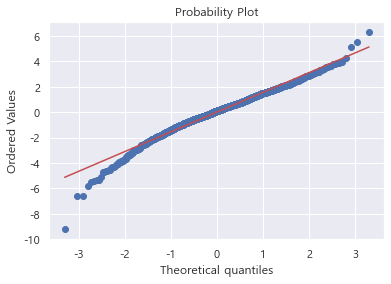

humidity


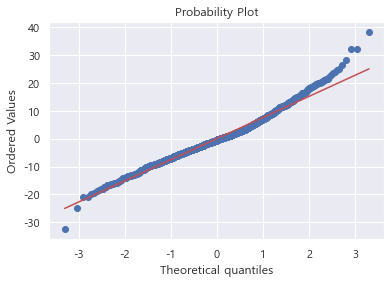

wind_speed


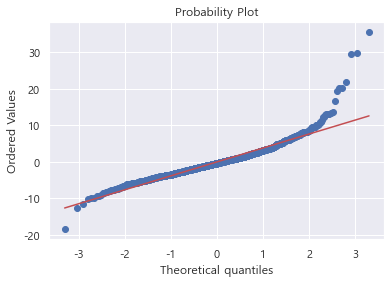

meanpressure


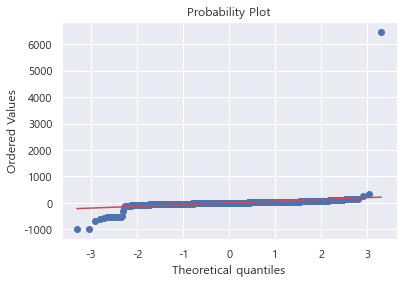

In [301]:
for col in results.resid.columns :
    print("{}".format(col))
    probplot(results.resid[col],plot = plt)
    plt.show()

meantemp


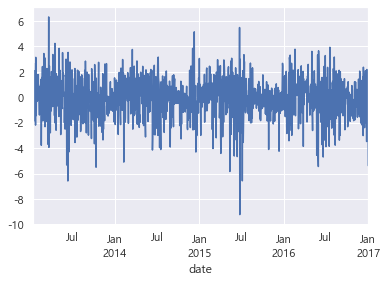

humidity


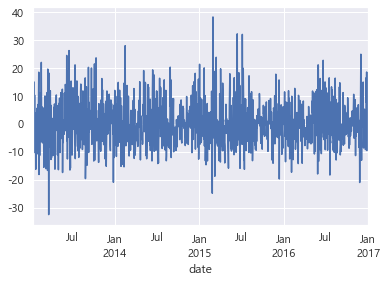

wind_speed


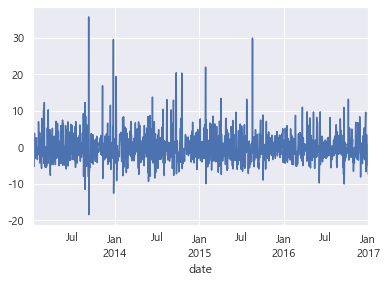

meanpressure


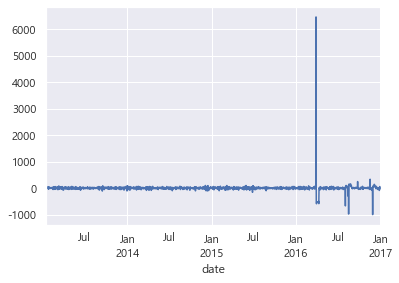

In [308]:
for col in results.resid.columns :
    print("{}".format(col))
    results.resid[col].plot()
    plt.show()

# 2. 회귀분석
- 예측대상 = value

## 2-1. 데이터를 전처리 한 후 시각화를 진행하고 해석하시오.

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('font',family = 'Malgun Gothic')
plt.rc('axes',unicode_minus = False)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from scipy.stats import probplot
import scipy.stats as stats
import math
import patsy
from sklearn.linear_model import Ridge,Lasso,ElasticNet

In [109]:
fifa = pd.read_csv('FIFA.csv')

In [113]:
fifa.describe(include='object')

,Name,Nationality,Club,Preferred_Foot,Work_Rate,Position,Height
count,16642,16642,16642,16642,16642,16642,16642
unique,15770,161,651,2,9,27,21
top,J. Rodr?guez,England,Real Madrid,Right,Medium/ Medium,ST,6'0
freq,9,1475,33,12822,9018,1924,2627


In [114]:
fifa.describe()

,ID,Age,Overall,Jersey_Number,Contract_Valid_Until,Weight_lb,Release_Clause,Value,Wage
count,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000,16642.000000
mean,213846.073849,25.225754,66.162180,19.657794,2020.241257,165.988162,4584.939911,2442.530946,9.618375
std,30546.895337,4.716345,7.008032,16.055119,1.290654,15.575286,11119.040864,5720.773674,22.264145
min,16.000000,16.000000,46.000000,1.000000,2018.000000,110.000000,13.000000,10.000000,1.000000
25%,199571.250000,21.000000,62.000000,8.000000,2019.000000,154.000000,525.000000,300.000000,1.000000
50%,221497.500000,25.000000,66.000000,17.000000,2020.000000,165.000000,1100.000000,675.000000,3.000000
75%,236803.000000,29.000000,71.000000,26.000000,2021.000000,176.000000,3500.000000,2000.000000,8.000000
max,246620.000000,45.000000,94.000000,99.000000,2026.000000,243.000000,228100.000000,118500.000000,565.000000


In [115]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16642 entries, 0 to 16641
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    16642 non-null  int64 
 1   Name                  16642 non-null  object
 2   Age                   16642 non-null  int64 
 3   Nationality           16642 non-null  object
 4   Overall               16642 non-null  int64 
 5   Club                  16642 non-null  object
 6   Preferred_Foot        16642 non-null  object
 7   Work_Rate             16642 non-null  object
 8   Position              16642 non-null  object
 9   Jersey_Number         16642 non-null  int64 
 10  Contract_Valid_Until  16642 non-null  int64 
 11  Height                16642 non-null  object
 12  Weight_lb             16642 non-null  int64 
 13  Release_Clause        16642 non-null  int64 
 14  Value                 16642 non-null  int64 
 15  Wage                  16642 non-null

In [118]:
fifa = fifa.iloc[:,2:]

In [151]:
object_col  =[col for col in fifa.columns if fifa[col].dtypes == 'object']
numeric_col  =[col for col in fifa.columns if fifa[col].dtypes != 'object']

<AxesSubplot:>

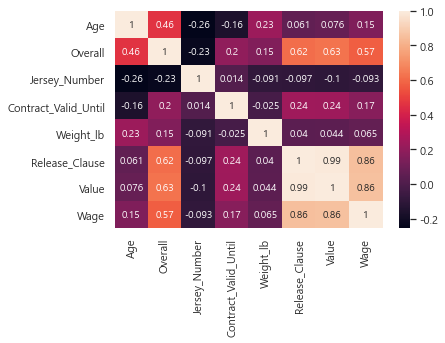

In [137]:
sns.heatmap(fifa.corr(),annot=True)

- Release_Clause랑 Value, Release_Clause랑 wage도 상관관계가 높으니 제거

In [158]:
df = fifa.drop(['Wage','Release_Clause'],axis = 1)

In [159]:
for col in numeric_col :
    if col in df.columns:
        print("{}의 skew : {}\n".format(col,df[col].skew()))

Age의 skew : 0.3374718049453631

Overall의 skew : 0.08412763486041759

Jersey_Number의 skew : 2.157999186759315

Contract_Valid_Until의 skew : 0.42255568211272043

Weight_lb의 skew : 0.20953673869869538

Value의 skew : 7.001402587711277



- Jersey_Number와 Value의 경우 왜도 값이 1이상이 되어있으므로 log변환을 수행한다.

In [162]:
df['Jersey_Number'] = np.log1p(df['Jersey_Number'])

In [165]:
df['Value'] = np.log1p(df['Value'])

In [168]:
def elbow_kmeans(data,col) :
    dataf = data[[col]]
    sse = {}
    for k in range(1,10) :
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(dataf)
        dataf['Clusters'] = kmeans.labels_
        sse[k] = kmeans.inertia_
        
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Num of Cluster")
    plt.show()

In [173]:
kmeans_df = pd.DataFrame(df.groupby('Club')['Value'].mean()).reset_index()

In [175]:
from sklearn.cluster import KMeans

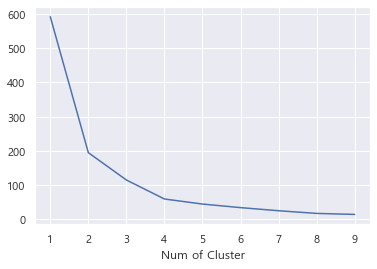

In [176]:
elbow_kmeans(kmeans_df,'Value')

- 4

In [180]:
kmeans = KMeans(n_clusters=4)

kmeans_df['ClubValueCluster'] = kmeans.fit_predict(kmeans_df[['Value']])

In [186]:
kmeans_df.groupby('ClubValueCluster')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
ClubValueCluster,,,,,,,,
0,229.0,5.711332,0.314071,4.385006,5.561311,5.768903,5.947253,6.133942
1,220.0,6.557725,0.241258,6.138716,6.363061,6.562973,6.765971,6.971845
2,126.0,7.409124,0.284620,6.989000,7.132151,7.391865,7.664896,7.939090
3,76.0,8.486609,0.432309,7.957534,8.164458,8.375821,8.809216,9.875246


In [185]:
kmeans_df = order_cluster('ClubValueCluster','Value',kmeans_df,ascending = True)

In [183]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [191]:
df = pd.merge(df,kmeans_df[['Club','ClubValueCluster']],on='Club')

In [194]:
df = df.drop(['Club'],axis = 1)

In [203]:
kmeans_df = pd.DataFrame(df.groupby('Nationality')['Value'].mean()).reset_index()

In [204]:
kmeans = KMeans(n_clusters=4)

kmeans_df['NationValueCluster'] = kmeans.fit_predict(kmeans_df[['Value']])

In [206]:
kmeans_df = order_cluster('NationValueCluster','Value',kmeans_df,ascending = True)

In [208]:
kmeans_df.groupby('NationValueCluster')['Value'].describe()

,count,mean,std,min,25%,50%,75%,max
NationValueCluster,,,,,,,,
0,17.0,5.449873,0.364365,4.619513,5.301546,5.525453,5.673323,5.834572
1,58.0,6.245131,0.216360,5.871787,6.054439,6.244126,6.432183,6.614989
2,48.0,7.016319,0.174949,6.669209,6.888248,7.040624,7.156584,7.309250
3,38.0,7.628023,0.355819,7.332060,7.419836,7.484427,7.732331,9.259226


In [210]:
df = pd.merge(df,kmeans_df[['Nationality','NationValueCluster']],on='Nationality')

In [214]:
df = df.drop(['Nationality'],axis = 1)

In [216]:
df.drop(['Height'],axis = 1, inplace = True)

In [224]:
df['Position'].unique()

array(['RF', 'LF', 'RM', 'GK', 'CB', 'ST', 'LW', 'LM', 'CAM', 'LCB',
       'RCB', 'LB', 'CM', 'CDM', 'LCM', 'RW', 'LS', 'RB', 'LDM', 'LWB',
       'RCM', 'RDM', 'RS', 'RWB', 'LAM', 'CF', 'RAM'], dtype=object)

In [225]:
position_list = []
for position in df['Position'] :
    if position.endswith('M') :
        position_list.append("MF")
    elif position.endswith("B") :
        position_list.append("DF")
    elif position == 'GK' :
        position_list.append("GK")
    else :
        position_list.append("FW")

In [228]:
df['Position'] = position_list

In [232]:
df = pd.get_dummies(columns = [col for col in df.columns if df[col].dtypes=='object'],data = df,drop_first = True)

In [259]:
df.columns = [col.replace('/ ','_') for col in df.columns]

## 2-2. 변수 선택법 중 하나를 택하여 최적의 회귀 모형을 탐색한 후 추정된 회귀식을 해석하시오.

In [111]:
import itertools
import time
import statsmodels.api as sm

def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    X_model = X[list(('Intercept',)+feature_set)]
    model = sm.OLS(y, X_model)
    regr = model.fit()
    RSS = (regr.resid ** 2).sum()
    return {"model":regr, "RSS":RSS, "AIC": regr.aic, 
            "BIC": regr.bic, "adj_r2": regr.rsquared_adj,
           "r2":regr.rsquared }

def getBest(k, best = "AIC"):
    
    tic = time.time()   
    results = []
    
    for combo in itertools.combinations(X.columns[1:], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    if best=="adj_r2" or best=="r2":
        best_model = models.loc[models[best].argmax()]
    else: 
        best_model = models.loc[models[best].argmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [241]:
value = df['Value']
df.drop(['Value'],axis = 1,inplace = True)

In [242]:
df['Value'] = value

In [260]:
import patsy
y, X = patsy.dmatrices('Value~'+"+".join(df.columns[:-1]), data = df, return_type='dataframe')

In [261]:
models_best = pd.DataFrame(columns=["model", "RSS","AIC","BIC","adj_r2", "r2"])

for i in range(1,X.shape[1]-1):
    models_best.loc[i] = getBest(i, best = "AIC")

Processed 19 models on 1 predictors in 0.12818050384521484 seconds.
Processed 171 models on 2 predictors in 0.9074890613555908 seconds.
Processed 969 models on 3 predictors in 6.105552434921265 seconds.
Processed 3876 models on 4 predictors in 39.76954436302185 seconds.
Processed 11628 models on 5 predictors in 156.5595841407776 seconds.


KeyboardInterrupt: 

In [262]:
models_best

,model,RSS,AIC,BIC,adj_r2,r2
1,<statsmodels.regression.linear_model.Regressio...,4023.855597,23605.484573,23620.923943,0.879211,0.879218
2,<statsmodels.regression.linear_model.Regressio...,1179.811167,3189.645284,3212.804339,0.964582,0.964586
3,<statsmodels.regression.linear_model.Regressio...,1099.208504,2013.990482,2044.869222,0.967000,0.967006
4,<statsmodels.regression.linear_model.Regressio...,1016.100265,707.623924,746.222348,0.969493,0.969500
5,<statsmodels.regression.linear_model.Regressio...,996.891427,392.003949,438.322059,0.970068,0.970077


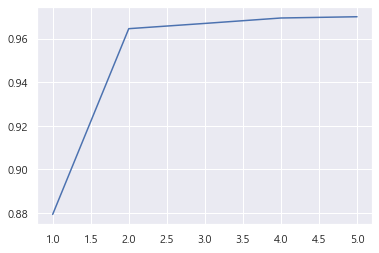

In [265]:
plt.plot(models_best['adj_r2'])
plt.show()

In [266]:
model_final = models_best.iloc[models_best['adj_r2'].argmax(),0]

In [267]:
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 1.079e+05
Date:                Thu, 03 Jun 2021   Prob (F-statistic):               0.00
Time:                        14:20:55   Log-Likelihood:                -190.00
No. Observations:               16642   AIC:                             392.0
Df Residuals:                   16636   BIC:                             438.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.4282      0.018   -294.146      0.000      -5.464      -5.392
Age            -0.0955      0.000   -207.979      0.000      -0.096      -0.095
Overall         0.2183      0.000    706.959      0.000       0.218       0.219
Position_FW     0.2045      0.006     36.837      0.000       0.194       0.215
Position_GK    -0.1175      0.007    -17.904      0.000      -0.130      -0.105
Position_MF     0.1503      0.005     33.038      0.000       0.141       0.159
==============================================================================
Omnibus:                     4061.799   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22249.317
Skew:                          -1.065   Prob(JB):                         0.00
Kurtosis:                       8.249   Cond. No.                         695.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2-3. 사후 검정을 실시하고 해석하시오.

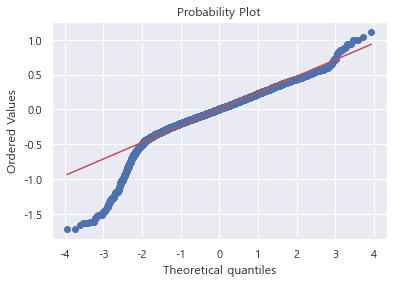

In [277]:
probplot(model_final.resid,plot = plt)
plt.show()

In [278]:
durbin_watson(model_final.resid)

1.575251368563683

- 2와 가까우므로 자기 상관성이 없으므로 독립이다.

Text(0, 0.5, 'Residuals')

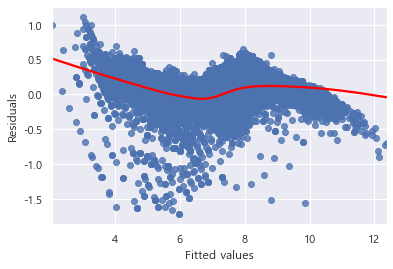

In [280]:
sns.regplot(model_final.fittedvalues,model_final.resid,lowess=True,line_kws={'color' : "red"})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

In [283]:
inf3 = OLSInfluence(model_final)

Text(0, 0.5, 'Standardized Residuals')

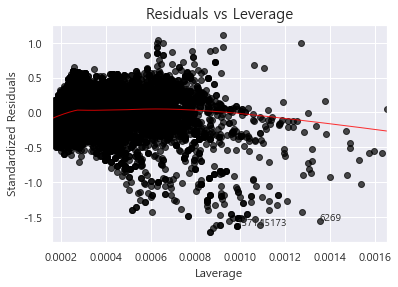

In [286]:
plt.scatter(model_final.get_influence().hat_matrix_diag, model_final.resid, color = 'black', alpha = .7)
sns.regplot(model_final.get_influence().hat_matrix_diag, model_final.resid,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
leverage_top_3 = np.flip(np.argsort(model_final.get_influence().cooks_distance[0]), 0)[:3]
for i in leverage_top_3:
    plt.annotate(i, xy=(model_final.get_influence().hat_matrix_diag[i],
                                 model_final.resid[i]));
plt.title('Residuals vs Leverage', size = 15)
plt.xlabel('Laverage')
plt.ylabel("Standardized Residuals")